In [1]:
# Imports PIL module
import urllib.request
from PIL import Image
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData')
#image = Image.open('T001.jpg')
#plt.imshow(image)

Mounted at /content/drive


In [2]:
!pip install -q datasets sentencepiece tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [3]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
# Check the current working directory
curr_path = os.getcwd()
print(curr_path)

# Change the current working directory
#os.path.join(curr_path,"key"))
#os.chdir('/content/drive/My Drive/Colab Notebooks/data/img')


# Load dataset
dataset = load_dataset("imagefolder", data_dir=curr_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

/content/drive/MyDrive/Colab Notebooks/Engine_TestData


Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 9 images
Dataset features are: dict_keys(['text', 'image'])


In [8]:
!pip install transformers==4.45.2 sentence-transformers==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Random sample is 8
OCR text is {"Work Order No": "JC42287634", "Aircraft Registration No": "N5391J", "Aircraft Type": "Cessna 206", "Aircraft Serial No": "FG1418", "Aircraft Total Hours": "3400", "Aircraft Total Cycles": "2400", "Engine Serial No": "LM191434", "Engine Total Hours": "1800", "Date": "01/08/2034", "Repair Station No": "CA1312"}


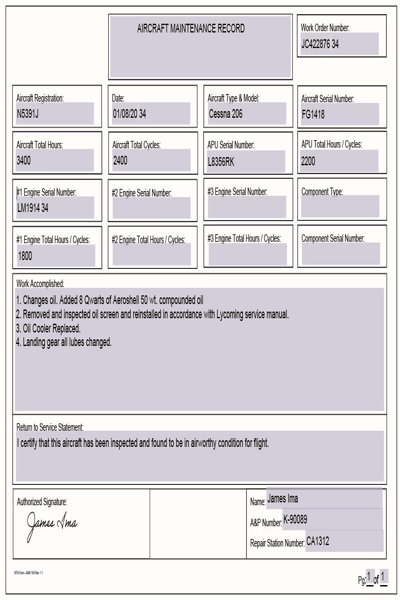

In [4]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((400,600))

In [5]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[5]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Sample: <s><s_Work Order No>JC42201212</s_Work Order No><s_Repair Station No>CA1312</s_Repair Station No><s_Engine Total Hours>2000</s_Engine Total Hours><s_Engine Serial No>HG567RE</s_Engine Serial No><s_Date>05/11/2012</s_Date><s_Aircraft Type>Cessna 206</s_Aircraft Type><s_Aircraft Total Hours>3200</s_Aircraft Total Hours><s_Aircraft Total Cycles>2300</s_Aircraft Total Cycles><s_Aircraft Serial No>KG6418</s_Aircraft Serial No><s_Aircraft Registration No>FY388M</s_Aircraft Registration No></s>
New special tokens: ['<s_TBO>', '</s_TBO>', '<s_Model No>', '</s_Model No>', '<s_Hub Serial No>', '</s_Hub Serial No>', '<s_Engine Manufacturer>', '</s_Engine Manufacturer>', '<s_Date>', '</s_Date>', '<s_Blade Design No>', '</s_Blade Design No>', '<s_Aircraft Registration No>', '</s_Aircraft Registration No>', '<s_Work Order No>', '</s_Work Order No>', '<s_Repair Station No>', '</s_Repair Station No>', '<s_Engine Total Hours>', '</s_Engine Total Hours>', '<s_Engine Serial No>', '</s_Engine Seri

In [7]:
print(f"Sample: {proc_dataset[5]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Sample: <s><s_Work Order No>JC42201212</s_Work Order No><s_Repair Station No>CA1312</s_Repair Station No><s_Engine Total Hours>2000</s_Engine Total Hours><s_Engine Serial No>HG567RE</s_Engine Serial No><s_Date>05/11/2012</s_Date><s_Aircraft Type>Cessna 206</s_Aircraft Type><s_Aircraft Total Hours>3200</s_Aircraft Total Hours><s_Aircraft Total Cycles>2300</s_Aircraft Total Cycles><s_Aircraft Serial No>KG6418</s_Aircraft Serial No><s_Aircraft Registration No>FY388M</s_Aircraft Registration No></s>
New special tokens: ['<s_TBO>', '</s_TBO>', '<s_Model No>', '</s_Model No>', '<s_Hub Serial No>', '</s_Hub Serial No>', '<s_Engine Manufacturer>', '</s_Engine Manufacturer>', '<s_Date>', '</s_Date>', '<s_Blade Design No>', '</s_Blade Design No>', '<s_Aircraft Registration No>', '</s_Aircraft Registration No>', '<s_Work Order No>', '</s_Work Order No>', '<s_Repair Station No>', '</s_Repair Station No>', '<s_Engine Total Hours>', '</s_Engine Total Hours>', '<s_Engine Serial No>', '</s_Engine Seri

In [9]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/donut/processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [10]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [11]:
print(f"Sample1: {processed_dataset[8]}")
print(f"New special tokens1: {new_special_tokens + [task_start_token] + [eos_token]}")
print(f"Sample2: {processed_dataset[5]}")
print(f"New special tokens2: {new_special_tokens + [task_start_token] + [eos_token]}")

In [12]:
## COMMENT IN in case you want to save the processed dataset to disk in case of error later
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData/')
processed_dataset.save_to_disk("processed_dataset")
processor.save_pretrained("processor")

Saving the dataset (0/1 shards):   0%|          | 0/9 [00:00<?, ? examples/s]

[]

In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.15)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 127
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 23
    })
})


In [ ]:
!pip install transformers==4.45.2 sentence-transformers==3.1.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


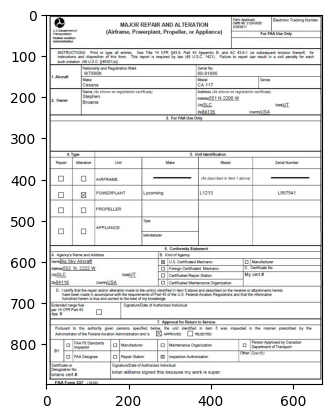

In [ ]:
# Imports PIL module
import urllib.request
from PIL import Image
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset/img')
image = Image.open('E017.jpg')
#image = plt.imread('list1.jpg')
plt.imshow(image)

In [ ]:
#!pip install -q git+https://github.com/huggingface/transformers.git

import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
#model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


New embedding size: MBartScaledWordEmbedding(57638, 1024, padding_idx=1)


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-engine_logbook"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=20,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

# Start training
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
50,5.005000
100,0.972300
150,0.280200
200,0.164300
250,0.105700
300,0.085600
350,0.068900


Step,Training Loss
50,5.005000
100,0.972300
150,0.280200
200,0.164300
250,0.105700
300,0.085600
350,0.068900
400,0.082300
450,0.044200
500,0.022900


TrainOutput(global_step=640, training_loss=0.5399263188242912, metrics={'train_runtime': 3683.3327, 'train_samples_per_second': 0.69, 'train_steps_per_second': 0.174, 'total_flos': 4.467575021395968e+18, 'train_loss': 0.5399263188242912, 'epoch': 20.0})

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

events.out.tfevents.1744821266.a6339d061ad1.3375.0:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/1992anubhav/donut-base-engine_logbook/commit/0dc586c259fb9029c93cb4cdfb218a770aeba0f0', commit_message='End of training', commit_description='', oid='0dc586c259fb9029c93cb4cdfb218a770aeba0f0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/1992anubhav/donut-base-engine_logbook', endpoint='https://huggingface.co', repo_type='model', repo_id='1992anubhav/donut-base-engine_logbook'), pr_revision=None, pr_num=None)

torch.Size([1, 3, 960, 720])


'\nprediction = processor.batch_decode(outputs.sequences)[0]\nprediction = processor.token2json(prediction)\n\n# load reference target\ntarget = processor.token2json(test_sample["target_sequence"])\n\nprint(f"Reference:\n {target}")\nprint(f"Prediction:\n {prediction}")\n\npixel_values = np.squeeze(test_sample["pixel_values"])\n#print(pixel_values)\npixel_values = (pixel_values + 1) / 2\n#processor.feature_extractor.to_pil_image(pixel_values)\nto_pil_image(pixel_values)'

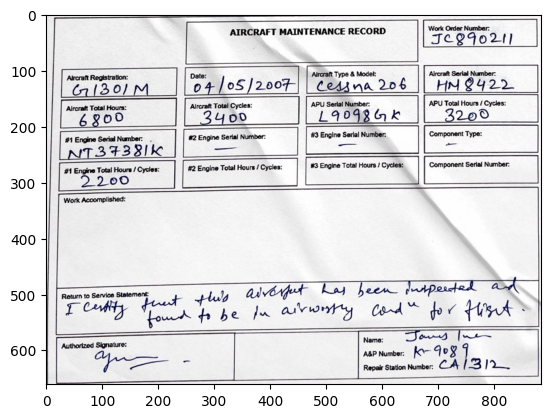

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")
'''
test_sample = processed_dataset["test"][random.randint(1, 8)]
pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
'''
os.chdir('/content/drive/My Drive/Colab Notebooks/Logbook_Dataset/RTS')
image = Image.open('N032.jpg')
#os.chdir('/content/drive/My Drive/Colab Notebooks/Test_Data')
#image = Image.open('T001.jpg')
#image = plt.imread('list1.jpg')
plt.imshow(image)
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

#task_prompt = "<s_cord-v2>"
task_prompt = "<s>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

'''
# Load random document image from the test set
#test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
pixel_values = np.squeeze(test_sample["pixel_values"])
#print(pixel_values)
pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(pixel_values)
to_pil_image(pixel_values)
'''

# process output
'''
prediction = processor.batch_decode(outputs.sequences)[0]
prediction = processor.token2json(prediction)

# load reference target
target = processor.token2json(test_sample["target_sequence"])

print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

pixel_values = np.squeeze(test_sample["pixel_values"])
#print(pixel_values)
pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(pixel_values)
to_pil_image(pixel_values)'''


Reference:
 {'TBO': '1200', 'Model No': 'TFE758', 'Hub Serial No': 'F864401G', 'Engine Manufacturer': 'HONEYWELL', 'Date': '02/05/2008', 'Blade Design No': 'L-197', 'Aircraft Registration No': 'K223NY'}
Prediction:
 {'TBO': '1200', 'Model No': 'TFE758', 'Hub Serial No': 'F864401G', 'Engine Manufacturer': 'HONEYWELL', 'Date': '02/05/2008', 'Blade Design No': 'L-197', 'Aircraft Registration No': 'K223NY'}


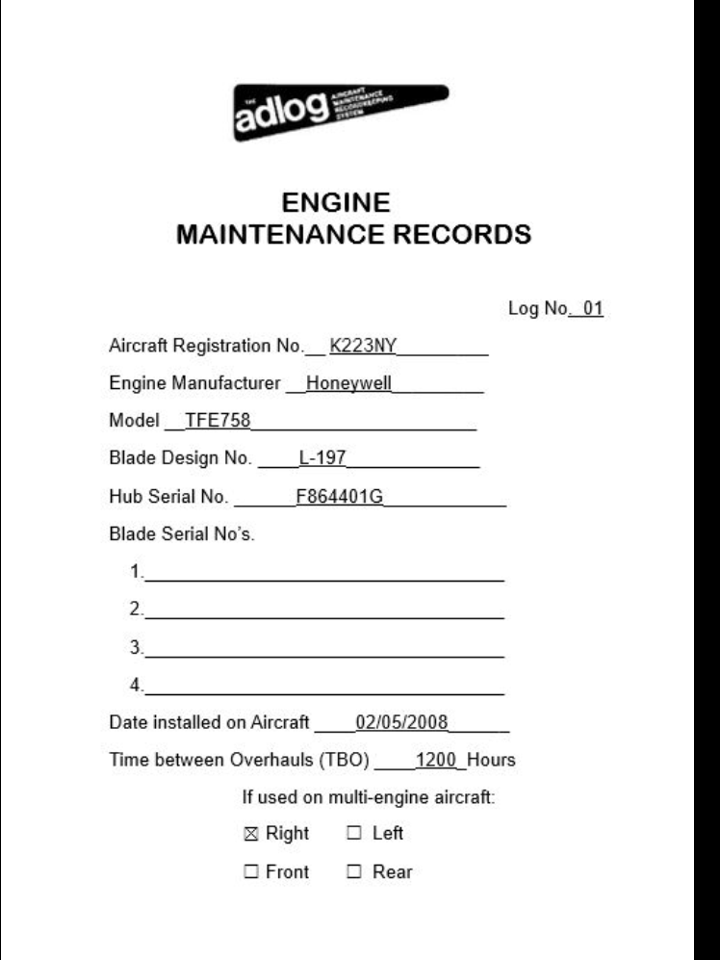

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
#transformers.logging.disable_default_handler()


# Load our model from Hugging Face
#processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
#model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")

test_sample = processed_dataset["test"][random.randint(1, 8)]
#print(pixel_values.shape)


def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
pixel_values = np.squeeze(test_sample["pixel_values"])
#print(pixel_values)
pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(pixel_values)
to_pil_image(pixel_values)



In [ ]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")

100%|██████████| 8/8 [00:12<00:00,  1.60s/it]

Accuracy: 100.0%


In [ ]:
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s><s><s_Work Order No> JC890211</s_Work Order No><s_Repair Station No> CA1312</s_Repair Station No><s_Engine Total Hours> 2200</s_Engine Total Hours><s_Engine Serial No> NT37381K</s_Engine Serial No><s_Date> 04/05/2007</s_Date><s_Aircraft Type> Cessna 206</s_Aircraft Type><s_Aircraft Total Hours> 6800</s_Aircraft Total Hours><s_Aircraft Total Cycles> 3400</s_Aircraft Total Cycles><s_Aircraft Serial No> HM8422</s_Aircraft Serial No><s_Aircraft Registration No> G1301M</s_Aircraft Registration No>
